In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Customer groups

To make it easier to see how an offer affects customers it's good to group them to similar groups.

Usually it is a good option to remove data rows with null values. However, I will keep them in this dataset because I like to think customers without gender, age and income details as a certain customer type: the ones that do not want to share their personal information.

#### Cleaning and scaling customer data

In [2]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [3]:
customers = profile
customers.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [4]:
# CHANGE UNKNOWN GENDERS TO LETTER U

customers['gender'].fillna('U', inplace=True)

In [5]:
# CHANGE BECAME MEMBER DATE TO YEAR

def set_member_year(data):
    data.became_member_on = data.became_member_on.fillna('19000101')
    new_data = data['became_member_on'] = data.became_member_on.apply(lambda x: str(x)[0:4])
    return new_data

customers = set_member_year(customers)

In [6]:
# SET AGE GROUPS

def set_age_groups(data):
    data['age'] = data.age.fillna(118)
    bins = (0, 20, 30, 40, 50, 60, 70, 80, 117, 120)
    edges = ['>20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '>80', 'Unknown']
    categories = pd.cut(data.age, bins, labels=edges)
    data['age'] = categories
    return data
    
customers = set_age_groups(profile)

In [7]:
# SET INCOME GROUPS

def set_income_groups(data):   
    data['income'] = data.income.fillna(-1)
    bins = (-2, 0, 45000, 60000, 75000, 90000, 120000)
    edges = ['secret', '<45000', '45001-60000', '60001-75000', '75001-90000', '>90001']
    categories = pd.cut(data.income, bins, labels=edges)
    data['income'] = categories
    return data
    
customers = set_income_groups(profile)

In [8]:
customers.rename(columns={'id':'customer_id'}, inplace=True)
customers = customers.set_index('customer_id')

In [9]:
customers.head(10)

,age,became_member_on,gender,income
customer_id,,,,
68be06ca386d4c31939f3a4f0e3dd783,Unknown,2017,U,secret
0610b486422d4921ae7d2bf64640c50b,50-60,2017,F,>90001
38fe809add3b4fcf9315a9694bb96ff5,Unknown,2018,U,secret
78afa995795e4d85b5d9ceeca43f5fef,70-80,2017,F,>90001
a03223e636434f42ac4c3df47e8bac43,Unknown,2017,U,secret
e2127556f4f64592b11af22de27a7932,60-70,2018,M,60001-75000
8ec6ce2a7e7949b1bf142def7d0e0586,Unknown,2017,U,secret
68617ca6246f4fbc85e91a2a49552598,Unknown,2017,U,secret
389bc3fa690240e798340f5a15918d5c,60-70,2018,M,45001-60000


In [10]:
# Changing grouped features to numbers (0 - number of unique values)

from sklearn import preprocessing

def encode_features(data):
    features = ['age', 'became_member_on', 'gender', 'income']
    
    for feature in features:
        label_encoder = preprocessing.LabelEncoder()
        label_encoder = label_encoder.fit(data[feature])
        data[feature] = label_encoder.transform(data[feature])
        
    return data
        
customers_encoded = encode_features(customers)

In [11]:
# scaling numerical features into a normalized range (0 - 1)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
customers_scaled=pd.DataFrame(scaler.fit_transform(customers.astype(float)))

# keep column names and customer_ids
customers_scaled.columns=customers.columns
customers_scaled.index=customers.index

customers_scaled.head(10)

,age,became_member_on,gender,income
customer_id,,,,
68be06ca386d4c31939f3a4f0e3dd783,1.000,0.8,1.000000,1.0
0610b486422d4921ae7d2bf64640c50b,0.375,0.8,0.000000,0.8
38fe809add3b4fcf9315a9694bb96ff5,1.000,1.0,1.000000,1.0
78afa995795e4d85b5d9ceeca43f5fef,0.625,0.8,0.000000,0.8
a03223e636434f42ac4c3df47e8bac43,1.000,0.8,1.000000,1.0
e2127556f4f64592b11af22de27a7932,0.500,1.0,0.333333,0.2
8ec6ce2a7e7949b1bf142def7d0e0586,1.000,0.8,1.000000,1.0
68617ca6246f4fbc85e91a2a49552598,1.000,0.8,1.000000,1.0
389bc3fa690240e798340f5a15918d5c,0.500,1.0,0.333333,0.0


#### Creating groups

Now we have nice scaled numerical data that can be used in a machine learning model. The current dataframe has 4 features so it is four dimensional.

Let's see how the features correlate to each other. If there were more features I would use PCA model to find the features that correlate the best but in this case it is unnecessary.

In [31]:
customers.corr()

,age,became_member_on,gender,income
age,1.000000,0.014169,0.550636,0.500667
became_member_on,0.014169,1.000000,0.024763,0.022697
gender,0.550636,0.024763,1.000000,0.505135
income,0.500667,0.022697,0.505135,1.000000


Text(0.5,1,'Correlation between different features')

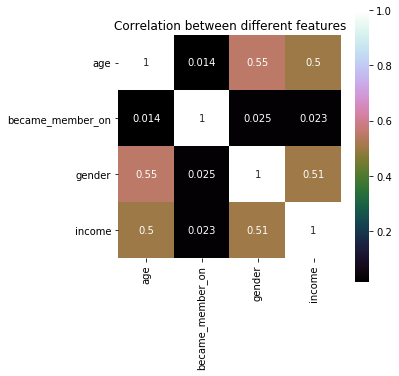

In [32]:
correlation = customers.corr()
plt.figure(figsize=(5,5))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different features')

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4) 
X_principal = pca.fit_transform(customers) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['age', 'gender', 'income', 'became_member_on'] 
  
X_principal.head()

,age,gender,income,became_member_on
0,5.452952,-0.542042,-0.289372,0.803941
1,0.020932,-1.865295,-0.256730,-1.130250
2,5.463842,-0.592210,-1.287968,0.790824
3,1.730713,-0.875261,-0.283756,-1.439688
4,5.452952,-0.542042,-0.289372,0.803941


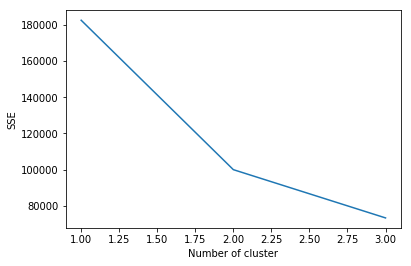

In [34]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, len(correlation)):
    kmeans = KMeans(n_clusters=k, max_iter=10).fit(X_principal)
    sse[k] = kmeans.inertia_ 
    # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [35]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_principal)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [36]:
# display the centroids
cluster_centroids=pd.DataFrame(kmeans.cluster_centers_)
cluster_centroids.columns=customers.columns

display(cluster_centroids)

,age,became_member_on,gender,income
0,0.397321,0.378038,0.012618,-0.432120
1,5.217386,-0.433374,-0.020294,0.572987
2,-2.281486,-0.259939,-0.006612,0.269648


In [37]:
age_center = kmeans.cluster_centers_[:, 0]
became_member_center = kmeans.cluster_centers_[:, 1]
gender_center = kmeans.cluster_centers_[:, 2]
income_center = kmeans.cluster_centers_[:, 3]

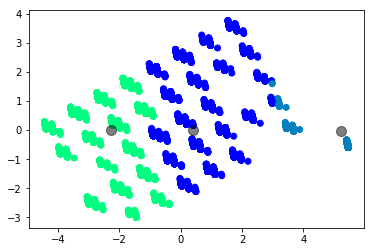

In [38]:
plt.scatter(X_principal['age'], X_principal['gender'],  
           c = KMeans(n_clusters = 3).fit_predict(X_principal), cmap =plt.cm.winter) 
centers = kmeans.cluster_centers_
plt.scatter(age_center, gender_center, c='black', s=100, alpha=0.5);
plt.show()

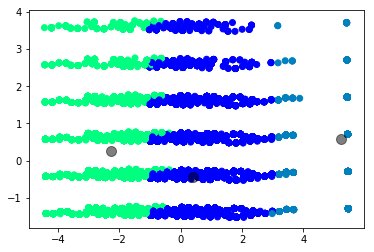

In [39]:
plt.scatter(X_principal['age'], X_principal['income'],  
           c = KMeans(n_clusters = 3).fit_predict(X_principal), cmap =plt.cm.winter) 
centers = kmeans.cluster_centers_
plt.scatter(age_center, income_center, c='black', s=100, alpha=0.5);
plt.show()

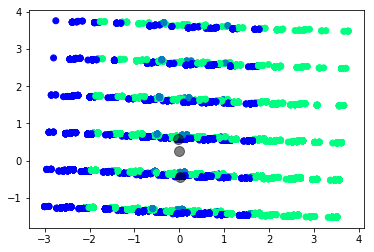

In [40]:
plt.scatter(X_principal['gender'], X_principal['income'],  
           c = KMeans(n_clusters = 3).fit_predict(X_principal), cmap =plt.cm.winter) 
centers = kmeans.cluster_centers_
plt.scatter(gender_center, income_center, c='black', s=100, alpha=0.5);
plt.show()

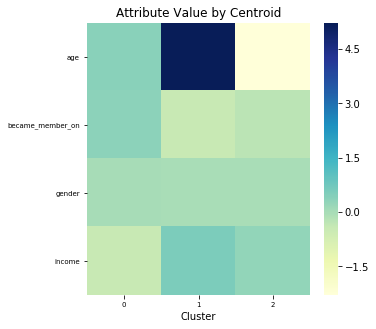

In [41]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (5,5))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 7)
plt.xticks(fontsize = 7)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [42]:
kmeans.labels_

array([1, 0, 1, ..., 2, 0, 0], dtype=int32)

In [43]:
test_label = profile
test_label['labels']=list(map(int, kmeans.labels_))
test_label[10:20]

,age,became_member_on,gender,customer_id,income,labels
10,Unknown,2017,U,c4863c7985cf408faee930f111475da3,secret,1
11,Unknown,2015,U,148adfcaa27d485b82f323aaaad036bd,secret,1
12,50-60,2017,M,2eeac8d8feae4a8cad5a6af0499a211d,45001-60000,2
13,60-70,2017,F,aa4862eba776480b8bb9c68455b8c2e1,45001-60000,0
14,20-30,2014,M,e12aeaf2d47d42479ea1c4ac3d8286c6,45001-60000,2
15,60-70,2016,F,31dda685af34476cad5bc968bdb01c53,60001-75000,0
16,40-50,2014,M,62cf5e10845442329191fc246e7bcea3,45001-60000,2
17,Unknown,2017,U,744d603ef08c4f33af5a61c8c7628d1c,secret,1
18,50-60,2017,M,6445de3b47274c759400cd68131d91b4,<45000,0
19,60-70,2018,F,a448667f336b42c9a66fc5ffd5d73772,<45000,0


In [44]:
len(test_label[test_label['labels']==0])

7595

In [45]:
len(test_label[test_label['labels']==1])

2459

In [46]:
len(test_label[test_label['labels']==2])

6946